In [1]:
import numpy as np
import pandas as pd
from math import radians, cos, sin, sqrt, atan2
import gstlearn.plot as gp
import gstlearn as gl
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = 'data/pdh_data.parquet'
df_utilisateur = pd.read_parquet(data)

In [3]:
# Filtrer pour ne garder que les colonnes 'category', 'lat', et 'lon'
df_utilisateur = df_utilisateur[['category', 'lat', 'lon','country']]

df_utilisateur = df_utilisateur[(df_utilisateur['lon'] > -5) & (df_utilisateur['lon'] < 9) &
                                (df_utilisateur['lat'] > 42) & (df_utilisateur['lat'] < 51.4)]
# Filtrer les lignes où la colonne 'category' contient 'Known PFAS user' ou 'Presumptive'
df_utilisateur = df_utilisateur[df_utilisateur['category'].isin(['Known PFAS user', 'Presumptive'])]

df_utilisateur = df_utilisateur[df_utilisateur["country"].isin(["France","Belgium","Germany","Switzerland","Spain"])]

# Afficher le DataFrame filtré
print(df_utilisateur.shape)
print(df_utilisateur.head())

(3835, 4)
           category        lat       lon  country
2   Known PFAS user  50.223409  8.765597  Germany
3   Known PFAS user  47.858601  5.347156   France
6   Known PFAS user  48.834075  1.941592   France
7   Known PFAS user  51.373767  6.430256  Germany
16  Known PFAS user  50.880471  4.268786  Belgium


In [4]:
data = 'data/pfas_2023_surf_ground_drink.parquet'
df_observation = pd.read_parquet(data)

In [6]:
print(df_observation)
df_observation.head()

              lat       lon  pfas_sum
194750  41.392351  9.165047       4.1
194743  41.695461  8.948481       0.0
325551  41.718255  9.303876       0.0
194730  41.754673  8.859828       0.0
325421  41.768722  9.173763       0.0
...           ...       ...       ...
159310  50.787268  1.975412       0.0
159329  50.798708  2.143868       0.0
159250  50.834486  1.686862       0.0
159292  50.894631  1.839508       0.0
159230  50.934294  1.765432       0.0

[4120 rows x 3 columns]


,lat,lon,pfas_sum
194750,41.392351,9.165047,4.1
194743,41.695461,8.948481,0.0
325551,41.718255,9.303876,0.0
194730,41.754673,8.859828,0.0
325421,41.768722,9.173763,0.0


In [8]:
# Fonction pour calculer la distance entre deux points à partir des coordonnées latitude/longitude
def haversine(lat1, lon1, lat2, lon2):
    # Rayon de la Terre en kilomètres
    R = 6371.0
    
    # Conversion des degrés en radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Différences entre les coordonnées
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Formule de Haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Distance en kilomètres
    distance = R * c
    return distance

In [9]:
# Liste pour stocker les distances minimales
distances_min = []

# Pour chaque point d'observation de contamination
for i, row in df_observation.iterrows():
    print(i)
    lat1, lon1 = row['lat'], row['lon']
    
    # Calculer la distance entre ce point et tous les sites dans df_sites
    distances = df_utilisateur.apply(lambda site: haversine(lat1, lon1, site['lat'], site['lon']), axis=1)
    
    # Trouver la distance minimale (le site le plus proche)
    min_distance = distances.min()
    
    # Ajouter la distance minimale à la liste
    distances_min.append(min_distance)

# Ajouter la nouvelle colonne "distance_site" au dataframe de contamination
df_observation['distance_site'] = distances_min

194750
194743
325551
194730
325421
194716
325706
194693
194681
194703
194665
325267
325216
325115
194648
325654
194659
325607
194619
325864
194513
318548
194497
325505
318493
194527
194632
318640
318794
194608
194555
194581
325015
194428
325768
325756
194483
194471
194595
325814
341887
194568
318743
194456
194443
318892
194413
194366
194292
194351
194263
194289
194541
194321
194336
294686
194380
194395
194285
194266
319021
326010
194307
194245
194259
194135
194117
194165
194201
326213
194120
194019
193960
194054
194184
297227
319459
194007
193996
194147
194103
194230
194129
296171
194216
193957
194040
193983
193636
193530
193869
319246
193613
193361
193356
193743
193550
193838
193765
193584
193425
193570
193614
319495
193924
193595
331365
193513
193706
193472
193940
193508
193886
295954
193601
193511
193533
293315
193460
296069
193488
193609
294063
193900
193727
296085
192083
192636
192320
197016
192914
192842
192656
192826
192081
336621
319898
192554
192807
192747
193127
293486
192566

In [10]:
df_observation.head()

,lat,lon,pfas_sum,distance_site
194750,41.392351,9.165047,4.1,129.586067
194743,41.695461,8.948481,0.0,93.066029
325551,41.718255,9.303876,0.0,99.050189
194730,41.754673,8.859828,0.0,85.771498
325421,41.768722,9.173763,0.0,89.702452


In [11]:
# Calcul de la corrélation linéaire
corr_coef = df_observation['distance_site'].corr(df_observation['pfas_sum'])

# Régression linéaire
slope, intercept, r_value, p_value, std_err = linregress(df_observation['distance_site'], df_observation['pfas_sum'])

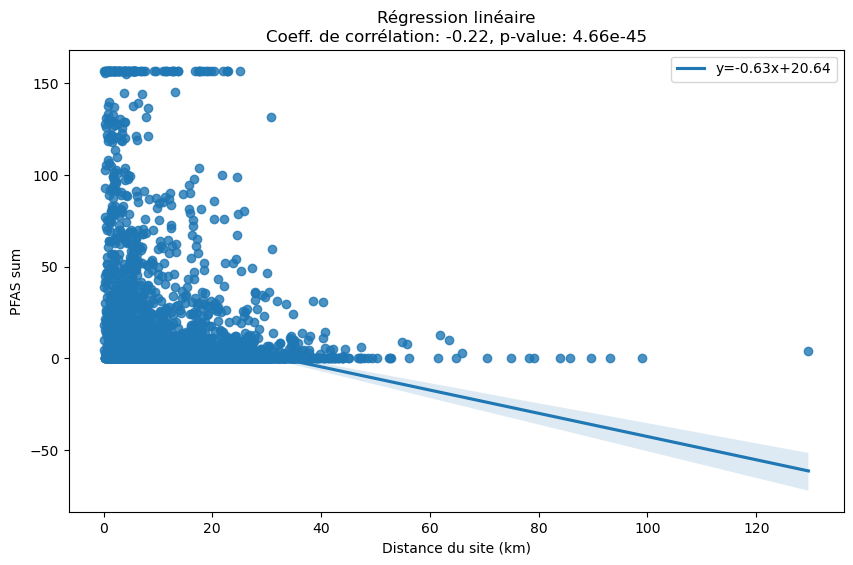

In [12]:
# Plot des données avec la régression linéaire
plt.figure(figsize=(10, 6))
sns.regplot(x='distance_site', y='pfas_sum', data=df_observation, line_kws={'label': f"y={slope:.2f}x+{intercept:.2f}"})
plt.xlabel('Distance du site (km)')
plt.ylabel('PFAS sum')
plt.title(f"Régression linéaire\nCoeff. de corrélation: {corr_coef:.2f}, p-value: {p_value:.2e}")
plt.legend()
plt.show()

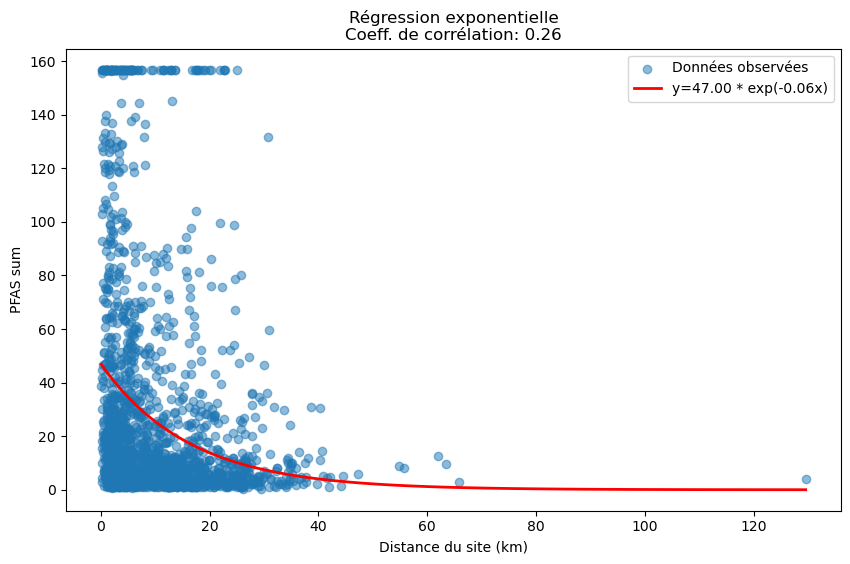

In [13]:
import numpy as np
from scipy.optimize import curve_fit

# Fonction exponentielle pour le fit
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Filtrer les données pour éviter les valeurs de PFAS négatives
df_filtered = df_observation[df_observation['pfas_sum'] > 0]

# Appliquer la régression exponentielle
x_data = df_filtered['distance_site']
y_data = df_filtered['pfas_sum']

# Ajustement du modèle
params, covariance = curve_fit(exp_func, x_data, y_data, p0=(1, -0.1))  # p0 sont les valeurs initiales pour a et b
a, b = params

# Générer les points pour la courbe de régression exponentielle
x_fit = np.linspace(x_data.min(), x_data.max(), 100)
y_fit = exp_func(x_fit, a, b)

# Calcul du coefficient de corrélation
corr_coef_exp = np.corrcoef(y_data, exp_func(x_data, *params))[0, 1]

# Plot des données avec la régression exponentielle
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Données observées', alpha=0.5)
plt.plot(x_fit, y_fit, color='red', label=f'y={a:.2f} * exp({b:.2f}x)', linewidth=2)
plt.xlabel('Distance du site (km)')
plt.ylabel('PFAS sum')
plt.title(f"Régression exponentielle\nCoeff. de corrélation: {corr_coef_exp:.2f}")
plt.legend()
plt.show()


In [16]:
df_observation.to_parquet('data/pfas_france_2023_dist_site.parquet')